# Neural Network from scratch in Python without any 3rd party library except numpy, pandas, and matplotlib

### Import Libraries

In [1]:
# importing libraries
import numpy as np
import pickle
import random
from matplotlib import pyplot as plt
from keras.datasets import fashion_mnist

### Load & Preprocess Dataset

Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)


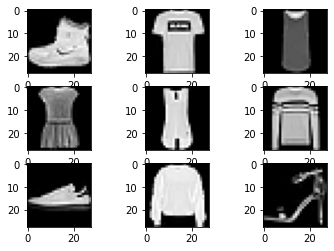

In [2]:
# load the Fashion MNIST dataset
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
# summarize loaded dataset
print('Train: X=%s, y=%s' % (X_train.shape, y_train.shape))
print('Test: X=%s, y=%s' % (X_test.shape, y_test.shape))
# plot first few images
for i in range(9):
    # define subplot
    plt.subplot(330 + 1 + i)
    # plot raw pixel data
    plt.imshow(X_train[i], cmap='gray')
# show the figure
plt.show()

In [3]:
# preprocess the data
X_train = X_train / 255.0
X_test = X_test / 255.0

In [4]:
y_train

array([9, 0, 0, ..., 3, 0, 5], dtype=uint8)

In [5]:
# get unique classes
np.unique(y_train)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [6]:
X_train.shape

(60000, 28, 28)

In [7]:
X_train[0].shape

(28, 28)

In [8]:
# originally the images in the dataset have no channel
# reshape the images in the dataset to have a single channel
'''
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2], 1))
'''
# flatten each of the images in the dataset into 1D arrays
X_train = X_train.reshape(-1, X_train.shape[1]*X_train.shape[2])
X_test = X_test.reshape(-1, X_test.shape[1]*X_test.shape[2])

In [9]:
X_train.shape

(60000, 784)

In [10]:
m, n = X_train.shape

In [11]:
X_train[0].shape

(784,)

In [12]:
X_train = X_train.T
X_train.shape

(784, 60000)

In [13]:
X_test = X_test.T
X_test.shape

(784, 10000)

In [14]:
arr = []
for i in X_train:
    arr.append(i[0])
print(len(arr))

784


### Neural Network

#### Train

In [15]:
# initialize the weights and biases with random values
def init_params():
    # initialization of weights can be done either by rand or randn
    # rand gives values from a uniform distribution in range [0, 1) with mean 0.5; we subtract the values by 0.5 to make the mean 0
    # randn gives values from a standard normal distribution with mean 0 and standard deviation 1, but it is not bounded due to which convergence or improvement in performance takes longer
    # initializing the weights to zero will lead all the neurons to learn the same features, which is not expected
    W1 = np.random.rand(10, 784) - 0.5
    # initialization of biases can be done either by rand or zeros
    # any of the options feasible since the non-zero weights will not let the gradients vanish
    b1 = np.random.rand(10, 1)
    W2 = np.random.rand(20, 10) - 0.5
    b2 = np.random.rand(20, 1)
    W3 = np.random.rand(10, 20) - 0.5
    b3 = np.random.rand(10, 1)
    return W1, b1, W2, b2, W3, b3

# define the activation functions
def relu(Z):
    return np.maximum(0, Z)

def relu_deriv(Z):
    return Z > 0

def softmax(Z):
    A = np.exp(Z) / sum(np.exp(Z))
    return A

# define the forward propagation
def forward(W1, b1, W2, b2, W3, b3, X):
    # calculate the activations for the first hidden layer
    Z1 = np.dot(W1, X) + b1
    A1 = relu(Z1)
    # calculate the activations for the second hidden layer
    Z2 = np.dot(W2, A1) + b2
    A2 = relu(Z2)
    # calculate the activations for the output layer
    Z3 = np.dot(W3, A2) + b3
    A3 = softmax(Z3)
    return Z1, A1, Z2, A2, Z3, A3

# one hot encoding
def one_hot(y):
    one_hot_y = np.zeros((y.size, y.max() + 1))
    one_hot_y[np.arange(y.size), y] = 1
    # the above line is similar to:
    # for i, j in zip(range(y.size), y):
    #   one_hot_y[i][j] = 1
    one_hot_y = one_hot_y.T
    return one_hot_y

# define the backward propagation
def backward(W1, Z1, A1, W2, Z2, A2, W3, Z3, A3, X, y):
    one_hot_y = one_hot(y)
    # calculate the change in weights and biases for the output layer
    dZ3 = A3 - one_hot_y
    dW3 = 1 / m * np.dot(dZ3, A2.T)
    db3 = 1 / m * np.sum(dZ3)
    # calculate the change in weights and biases for the second hidden layer
    dZ2 = np.dot(W3.T, dZ3) * relu_deriv(Z2)
    dW2 = 1 / m * np.dot(dZ2, A1.T)
    db2 = 1 / m * np.sum(dZ2)
    # calculate the change in weights and biases for the first hidden layer
    dZ1 = np.dot(W2.T, dZ2) * relu_deriv(Z1)
    dW1 = 1 / m * np.dot(dZ1, X.T)
    db1 = 1 / m * np.sum(dZ1)
    return dW1, db1, dW2, db2, dW3, db3

# update the parameters
def update_params(W1, b1, W2, b2, W3, b3, dW1, db1, dW2, db2, dW3, db3, alpha):
    W1 -= alpha * dW1
    b1 -= alpha * db1
    W2 -= alpha * dW2
    b2 -= alpha * db2
    W3 -= alpha * dW3
    b3 -= alpha * db3
    return W1, b1, W2, b2, W3, b3

In [16]:
# get predictions from the output layer
def get_predictions(A):
    return np.argmax(A, axis = 0)

# get accuracy value between 0 and 1
def get_accuracy(predictions, y):
    return np.sum(predictions == y) / y.size

# fit the neural network with optimzer: gradient descent
def gradient_descent(X, y, alpha, iterations):
    # get initial values of the weights and biases
    W1, b1, W2, b2, W3, b3 = init_params()
    for i in range(iterations):
        # forward pass - apply the current weights, biases, and activation on the input data to get output labels
        Z1, A1, Z2, A2, Z3, A3 = forward(W1, b1, W2, b2, W3, b3, X)
        # backward pass - calculate loss and gradients with respect to weights and biases
        dW1, db1, dW2, db2, dW3, db3 = backward(W1, Z1, A1, W2, Z2, A2, W3, Z3, A3, X, y)
        # update weights and biases based on calculated gradients
        W1, b1, W2, b2, W3, b3 = update_params(W1, b1, W2, b2, W3, b3, dW1, db1, dW2, db2, dW3, db3, alpha)
        # display prediction details every 100th epoch/iteration
        if i == 0 or (i+1) % 100 == 0:
            print("Iteration: {}".format(i + 1))
            predictions = get_predictions(A3)
            print("Predicted Labels: {}, True Labels: {}".format(predictions, y))
            print("Accuracy: {}".format(get_accuracy(predictions, y)))
    return W1, b1, W2, b2, W3, b3

In [17]:
# get final weights and biases
W1, b1, W2, b2, W3, b3 = gradient_descent(X_train, y_train, 0.10, 2000)

Iteration: 1
Predicted Labels: [3 3 3 ... 9 7 9], True Labels: [9 0 0 ... 3 0 5]
Accuracy: 0.05416666666666667
Iteration: 100
Predicted Labels: [9 0 3 ... 3 1 5], True Labels: [9 0 0 ... 3 0 5]
Accuracy: 0.6516166666666666
Iteration: 200
Predicted Labels: [9 0 3 ... 3 1 5], True Labels: [9 0 0 ... 3 0 5]
Accuracy: 0.6968333333333333
Iteration: 300
Predicted Labels: [9 0 3 ... 3 0 5], True Labels: [9 0 0 ... 3 0 5]
Accuracy: 0.7274833333333334
Iteration: 400
Predicted Labels: [9 0 3 ... 3 0 5], True Labels: [9 0 0 ... 3 0 5]
Accuracy: 0.75015
Iteration: 500
Predicted Labels: [9 0 3 ... 3 0 5], True Labels: [9 0 0 ... 3 0 5]
Accuracy: 0.7652166666666667
Iteration: 600
Predicted Labels: [9 0 3 ... 3 0 5], True Labels: [9 0 0 ... 3 0 5]
Accuracy: 0.77705
Iteration: 700
Predicted Labels: [9 0 3 ... 3 0 5], True Labels: [9 0 0 ... 3 0 5]
Accuracy: 0.783
Iteration: 800
Predicted Labels: [9 0 3 ... 3 0 5], True Labels: [9 0 0 ... 3 0 5]
Accuracy: 0.7913333333333333
Iteration: 900
Predicted Lab

In [18]:
# save the trained model parameters: weights and biases
params = (W1, b1, W2, b2, W3, b3)
params_file = open("params.pkl","wb")
pickle.dump(params, params_file)
params_file.close()

#### Test

In [19]:
# load the saved model parameters: weights and biases
params_file = open("params.pkl", "rb")
params = pickle.load(params_file)
W1, b1, W2, b2, W3, b3 = params
params_file.close()

In [20]:
def predict(X, W1, b1, W2, b2, W3, b3):
    _, _, _, _, _, A3 = forward(W1, b1, W2, b2, W3, b3, X)
    predictions = get_predictions(A3)
    return predictions

def visualize_predictions(idx, W1, b1, W2, b2, W3, b3):
    current_image = X_test[:, idx, None]
    prediction = predict(current_image, W1, b1, W2, b2, W3, b3)
    label = y_test[idx]
    print("Predicted Label: {}, True Label: {}".format(prediction, label))
    image_side = int(np.sqrt(X_test.T[idx].size))  # 28 is the value of each side of an image
    current_image = current_image.reshape((image_side, image_side)) * 255
    plt.imshow(current_image, cmap='gray')
    plt.show()

def test(X, y, W1, b1, W2, b2, W3, b3):
    y_predicted = predict(X, W1, b1, W2, b2, W3, b3)
    test_accuracy = get_accuracy(y_predicted, y)
    print("Test Accuracy: {}".format(test_accuracy))

In [21]:
# get the accuracy of the trained model on the test set that contains images NOT seen by the model yet
test(X_test, y_test, W1, b1, W2, b2, W3, b3)

Test Accuracy: 0.815


Predicted Label: [3], True Label: 3


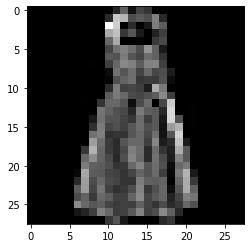

Predicted Label: [4], True Label: 4


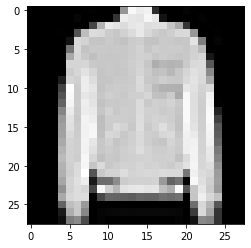

Predicted Label: [6], True Label: 6


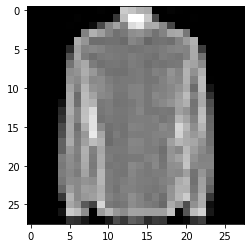

Predicted Label: [5], True Label: 5


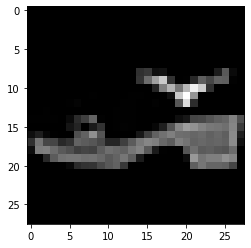

Predicted Label: [9], True Label: 9


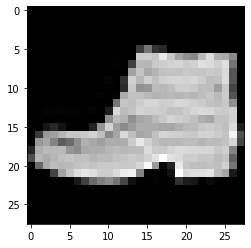

In [22]:
# visualize model predictions on images from test set
times = 5
for i in range(times):
    visualize_predictions(random.randint(0, X_test.shape[1]), W1, b1, W2, b2, W3, b3)